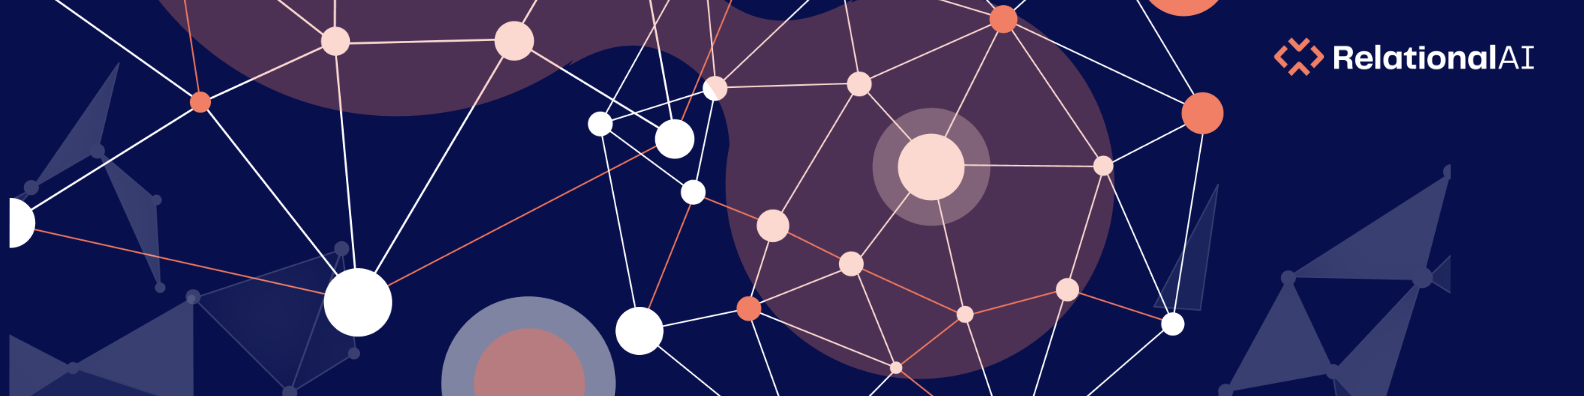

# Community Detection and Group Recommendations using RelationalAI

## Overview
In this notebook, we will review how to use RelationalAI to run community detection algorithms to identify communities of customers that eat together.

## What you will learn
- How to run all sorts of graph algorithms on our data, where it already lives, to discover new insights.
- How to visualize graphs.
- How thanks to native applications with Snowpark Container Services, we can do all of this within the Data Cloud!

***

## Let's get started!
We start by importing all the Python packages and modules that we will need.

In [5]:
import random
import colorsys

import relationalai as rai
from relationalai.clients.snowflake import Snowflake
from relationalai.std import aggregates, alias, rel
from relationalai.std.graphs import Graph
from relationalai.std import Vars


random.seed(123)

### Define Model in RelationalAI
Let's define our model object. **Models** represent collections of objects. **Objects**, like Python objects, have **types** and **properties**, which we will define in a bit.

In [31]:
model = rai.Model("SJB_LOYALTY_ORDERS_REGION_CALIFORNIA_12")

### Referencing Snowflake Data
Due to RelationalAI's tight integration with Snowflake, we can refer to data that we are streaming to our RelationalAI database by simply referring to sf.<my_database>.<my_schema.my_table>.

Let's run a small query to understand the shape of our data.

In [33]:
sf = Snowflake(model)

Record = sf.FROSTBYTE_TASTY_BYTES.HARMONIZED.LOYALTY_ORDERS_REGION_CALIFORNIA

In [34]:
# Count number of rows in the data
with model.query() as select:
    record = Record()
    num_records = aggregates.count(record)
    result = select(num_records)

result

result
1603564


### Type Declarations
Now that we know how to refer to our data within RAI, let's define our **Types**. Types are collections of objects. You create then using the `model.Type()` method, which returns an instance of the `Type` class.

Our data contains a set of **records** which are associated with a **Customer**, who buys food at a specific **Truck**. We'll describe the other types, namely  **Transaction** , **Community** and **RelevantConnection** in a little while, when we will actually be deriving this information.

In [35]:
Customer = model.Type("Customer")
Truck = model.Type("Trucks")
Transaction = model.Type("Transaction")
Community = model.Type("Community")
RelevantConnection = model.Type("RelevantConnection")

## Weaving data into our Model
It's time to start weaving our data into our model. We do this by writing some rules. **Rules describe objects in a model and the relationships between them**. They are created using the `model.rule()` context manager.

### Defining Customers
This rule adds an object to the `Customers` type for each occurrence of a unique `customer_id`. Let's run a query to see how many customers we have in our dataset.

In [36]:
# Define Customer Type
with model.rule():
    r = Record()
    Customer.add(customer_id=r.customer_id)

# Check total number of customers
with model.query() as select:
    customer = Customer()
    num_records = aggregates.count(customer)
    result = select(num_records)

result

result
10613


#### Defining Trucks
We do the same as we just did with customers - but now for `Trucks`.

In [37]:
# Define Truck Type
with model.rule():
    r = Record()
    Truck.add(truck_id=r.truck_id)

# Check total number of trucks
with model.query() as select:
    truck = Truck()
    num_records = aggregates.count(truck)
    result = select(num_records)

result

result
15


### Defining Transactions


We pull the relevant data about a `Transaction` from the `Records` in the table.

In [38]:
with model.rule():
    r = Record()
    Transaction.add(
        customer_id=r.customer_id,
        order_id=r.order_id,
        truck_id=r.truck_id,
        order_ts=r.order_ts,
        order_ts_seconds=r.order_ts_seconds,
        location_id=r.location_id,
    )

### Finding Connections
Identify pairs of transactions occurring within a 20-minute interval in the same truck.


In [39]:
with model.rule():
    t1 = Transaction()
    t2 = Transaction()

    t1.truck_id == t2.truck_id
    t1.customer_id != t2.customer_id
    rel.abs(t1.order_ts_seconds - t2.order_ts_seconds) <= 1200

    t1.connected.add(t2)

In [40]:
with model.query() as select:
    t = Transaction()
    num_records = aggregates.count(t.customer_id, t.order_ts, t.connected, t.connected.customer_id)
    result = select(num_records)

print(result)

 result
1214311


## Reducing connections to 'relevant' ones
To be able to assess the strength of a connection, we first need to know how often a specific connection occurred. We define a `RelevantConnection` as a connection where two customers have placed orders together more than once. Let's see how many relevant connections we have in our dataset.

Note. If you don't see any output after running the result query below, you may need to reduce number of total_connections > 4. Try 2 or 1 instead. If this happens, you have the current TastyBytes dataset. There is a custom dataset that RAI can share to your account using Snowflake's Data Share that has a richer social graph.

In [41]:
with model.rule():
    t = Transaction()
    total_connections = aggregates.count(
        t, per=[t.customer_id, t.connected.customer_id]
    )
    total_connections > 4
    RelevantConnection.add(
        customer_1=Customer(customer_id=t.customer_id),
        customer_2=Customer(customer_id=t.connected.customer_id),
        total_connections=total_connections,
    )

In [42]:
# Get the total occurrences where pairs of customers coexisted together more than once
with model.query() as select:
    relevant_con = RelevantConnection()
    num_records = aggregates.count(relevant_con)
    result = select(num_records)

result

result
9704


# Community Detection
Let's build out our community graph. Our **nodes** are our customers. We use the relevant connections between customers, that we have derived earlier, as the **edges** of our graph.

In [43]:
community_graph = Graph(model, undirected=True)

# Add edges to the graph between customers / Nodes will be added automatically
with model.rule():
    relevant_con = RelevantConnection()
    community_graph.Edge.add(
        relevant_con.customer_1,
        relevant_con.customer_2,
        weight=relevant_con.total_connections,
    )

## Detecting communities using Louvain
Let's use the **Louvain** algorithm to detect communities within our graph.

In [44]:
with model.rule():
    customer = Customer()
    community_id = community_graph.compute.louvain(customer)
    customer.set(community_id=community_id)

    community_graph.Node(customer).set(
        community_id=community_id,
        customer_id=customer.customer_id
    )

### Visualize Graph

In [45]:
def generate_random_colors(num_colors):
    """generate random color for each group in large graph."""
    colors = []
    for i in range(num_colors):
        hue = random.random()
        # adjust for better palette
        saturation = random.uniform(0.5, 1.0)
        lightness = random.uniform(0.4, 0.8)

        rgb_color = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append('#%02x%02x%02x' % tuple(int(255 * x) for x in rgb_color))
    return colors

In [46]:
data = community_graph.fetch()

num_nodes = len(data["nodes"])
num_edges = len(data["edges"])
print(f"Number of nodes: {num_nodes}, Number of edges: {num_edges}")

community_set = {node['community_id'] for node in data['nodes'].values() if 'community_id' in node}
num_communities = len(community_set)
print(f"Number of communities: {num_communities}")

random_colors = generate_random_colors(num_communities)

community_colors = {}
for i, community in enumerate(community_set):
    community_colors[community] = random_colors[i]

Number of nodes: 3493, Number of edges: 4939
Number of communities: 555


In [52]:
g = community_graph.visualize(
    three=True,
    node_label_size_factor=1.9,
    use_links_force=True,
    node_hover_neighborhood=True,
    style={
    "node": {
        "color": lambda x : community_colors[x['community_id']],
        "hover": lambda x : f"{x['customer_id']}"
    },
    "edge": {
        "opacity": 0.8,
        "color": "#ccc",
        "hover": lambda x : x['weight']
    }
})

In [64]:
data

{'nodes': defaultdict(dict,
             {'akDmijSiJW6NX4NghuxHAA': {'community_id': 1,
               'customer_id': '139628'},
              'B4F1hrH4yrds6RXy9fp1AA': {'community_id': 2,
               'customer_id': '197724'},
              'ky+JUydIIQeRFWjgCR19AA': {'community_id': 3,
               'customer_id': '40483'},
              '+YLdAvHQSDA0dv1Y8aKeAA': {'community_id': 4,
               'customer_id': '174484'},
              'waWyw5EhXnFXn4n8Mi2xAA': {'community_id': 5,
               'customer_id': '151417'},
              'LJJqgUablvNmJP0LZli+AA': {'community_id': 6,
               'customer_id': '81687'},
              'Zk+CqVsPzZcFhD+ULRvDAA': {'community_id': 7,
               'customer_id': '65532'},
              'K0fFtXAe+fqzZPy1m5DTAA': {'community_id': 8,
               'customer_id': '55109'},
              'Dk9QwmGL7tmgN8IdFl77AA': {'community_id': 9,
               'customer_id': '123963'},
              'QcqkI9YpT+sXk4poHdAYAQ': {'community_id': 10,
      

In [ ]:
## if I were to plot directly in the js library, then I just need to construct my graph ( nodes and edges ) into their input json format.
#import ForceGraph3D from '3d-force-graph';


In [77]:
%%javascript
require.config({
  paths: {
      gr: 'https://unpkg.com/3d-force-graph'
  }
});

<IPython.core.display.Javascript object>

In [121]:
from IPython.display import display, Javascript

def printgraph( mydata ):
    s= """

element.append("<div id='3d-graph' style='width: 500dpx; height: 500dpx'></div>");

require(['gr'], function (gr){
        
    const Graph = gr.ForceGraph3D()
    (document.getElementById('3d-graph'))
        .graphData(JSON.parse('DATA'))
        
    });

""".replace('DATA',mydata)
    print(s)

def plotgraph( mydata ):
    display(Javascript("""

element.append("<div id='3d-graph' style='width: 500dpx; height: 500dpx'></div>");

require(['gr'], function (gr){
        
    const myGraph = gr.ForceGraph3D();
    myGraph(document.getElementById('3d-graph'))
      .graphData(JSON.parse('DATA'))
    });

""".replace('DATA',mydata)))

In [126]:
from IPython.display import display, Javascript
import json

def plotgraph(mydata):
    display(Javascript("""
        element.append("<div id='3d-graph' style='width: 500px; height: 500px'></div>");

        require(['gr'], function (gr) {
            const myGraph = gr.ForceGraph3D();
            myGraph(document.getElementById('3d-graph'))
                .graphData(JSON.parse(arguments[0]));
        });
    """.replace('DATA', json.dumps(mydata))))

In [159]:
from IPython.display import display, Javascript
import json

def plotgraph(mydata):
    display(Javascript("""
        // Create the div element with styling
        const divElement = document.createElement("div");
        divElement.id = '3d-graph2';
        divElement.style.width = '500px';
        divElement.style.height = '500px';
        
        // Append the div to the document body
        document.body.appendChild(divElement);
        
        // Log the JSON data string
        const jsonDataString = `{json_data}`;
        console.log('JSON data string:', jsonDataString);

        // Parse the JSON data
        const jsonData = JSON.parse(jsonDataString);
        console.log('Parsed JSON data:', jsonData);

        // Load the 3d-force-graph library and create the graph
        require(['gr'], function (gr) {{
            console.log('3d-force-graph library loaded:', gr);

            const myGraph = gr.ForceGraph3D();
            console.log('Initialized ForceGraph3D:', myGraph);

            // Bind the graph to the div element and set the graph data
            myGraph(divElement)
                .graphData(jsonData);
            console.log('Graph data set');
        }});
    """.format(json_data=json.dumps(mydata))))
    
mydata = {
"nodes": [
        {
          "id": "id1",
          "name": "name1",
          "val": 1
        },
        {
          "id": "id2",
          "name": "name2",
          "val": 10
        }
    ],
    "links": [
        {
            "source": "id1",
            "target": "id2"
        }
    ]
}

plotgraph(mydata)

<IPython.core.display.Javascript object>

### Let's focus on a particular community. 

In [48]:
def get_community_id_of_customer( customer_id ):
    mycommunity = None
    for i in data.values():
        for p in i.values():
            try:
                if p['customer_id'] == customer_id:
                    mycommunity = p['community_id']
            except:
                pass
    return mycommunity

community_id_of_interest = get_community_id_of_customer(84087)
community_id_of_interest

In [49]:
community_colors_focus = {}
for i in range(1,len(community_colors)+1):
    community_colors_focus[i] = '#808080'

community_colors_focus[community_id_of_interest] = '#FF0000'

#
community_graph.visualize(
    three=True,
    node_label_size_factor=1.9,
    use_links_force=True,
    node_hover_neighborhood=True,
    style={
    "node": {
        "color": lambda x : community_colors_focus[x['community_id']],
        "size" : lambda x : 20 if x['community_id'] == community_id_of_interest else 2,
        "hover": lambda x : f"{x['customer_id']}"
    },
    "edge": {
        "opacity": 0.8,
        "color": "#ccc",

        "hover": lambda x : x['weight']
    }
})

In [50]:
graph_dict = graph._visual_dict(style={"node": {...}, "edge": {...}})
import gravis as gv
gv.d3(graph_dict)

NameError: name 'graph' is not defined

Brought to you by [RelationalAI](https://relational.ai/) & Snowflake Native Applications!